In [1]:
# Train SVM classifier
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from lesson_functions import *
%matplotlib inline

# Define a function to extract features from a list of images - Udacity Code
def extract_features(imgs, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL', sp_size=(16, 16), h_bins=16):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=cspace)
        #print (feature_image)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Get color features
        spatial_features = bin_spatial(feature_image, size=sp_size)
        hist_features = color_hist(feature_image, nbins=h_bins)
        
        # Append feature vectors to the features list
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))

    # Return list of feature vectors
    return features


# read in cars and notcars
cars = []
notcars = []

# extract every 5th not car image
notcar_ALL = glob.glob('non-vehicles/*.png')
skip_count = 0
for image in notcar_ALL:
    skip_count += 1
    if skip_count >= 5:
        notcars.append(image)
        skip_count = 0

# Extract every 5th car image to account for time series effect
# Extract every 5th non car image as well to create balanced dataset
car_KITTI = glob.glob('vehicles/*.png')
skip_count = 0
for image in car_KITTI:
    skip_count += 1
    if skip_count >= 5:
        cars.append(image)
        skip_count = 0

car_GTI_Far = glob.glob('vehicles/GTI_Far/*.png')
skip_count = 0
for image in car_GTI_Far:
    skip_count += 1
    if skip_count >= 5:
        cars.append(image)
        skip_count = 0

car_GTI_Left = glob.glob('vehicles/GTI_Left/*.png')
skip_count = 0
for image in car_GTI_Left:
    skip_count += 1
    if skip_count >= 5:
        cars.append(image)
        skip_count = 0

car_GTI_MiddleClose = glob.glob('vehicles/GTI_MiddleClose/*.png')
skip_count = 0
for image in car_GTI_MiddleClose:
    skip_count += 1
    if skip_count >= 5:
        cars.append(image)
        skip_count = 0

car_GTI_Right = glob.glob('vehicles/GTI_Right/*.png')
skip_count = 0
for image in car_GTI_Right:
    skip_count += 1
    if skip_count >= 5:
        cars.append(image)
        skip_count = 0

# Hyperparameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 16


t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, sp_size=spatial_size, h_bins=hist_bins)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, sp_size=spatial_size, h_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# save standard scaler so that it can be reused later
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(X_scaler, scaler_filename) 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('Feature vector length:', len(scaled_X[0]))

# Use GridSearch to find best parameter
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10], 'gamma':[0.1, 1, 10]}
#svr = SVC()
#CLASSIFIER = GridSearchCV(svr, parameters)

# Check the training time for the SVC
#t=time.time()
#CLASSIFIER.fit(scaled_X, y)
#t2 = time.time()
#print(round(t2-t, 2), 'Seconds to train SVC...')

14.68 Seconds to extract HOG features...
Feature vector length: 6108


In [2]:
# Train classifier again with best parameters

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

CLF = SVC(kernel="linear", C=0.1, gamma=0.1)
print (CLF)
CLF.fit(X_train, y_train)

# Save classifier so it can be reused later
classifier_filename = "classifier.save"
joblib.dump(CLF, classifier_filename) 

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(CLF.score(X_test, y_test), 4))

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Test Accuracy of SVC =  0.9845


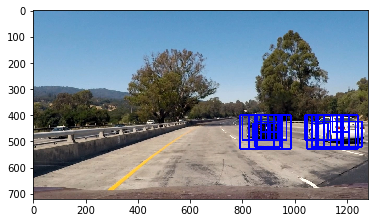

In [3]:
# Define a single function that can extract features using hog sub-sampling and make predictions - Udacity code with mod
def find_cars(img, xstart, ystart, ystop, scales_list, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    boxes = []
    
    # iterate through box windows of different scales
    for scale in scales_list:

        ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # = 105
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # = 20
        nfeat_per_block = orient*cell_per_block**2 # = 9*2^2 = 9*4 = 36

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 # = 7
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # = 49
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step # = 6

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step # position in cells
                xpos = xb*cells_per_step # position in cells
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                hog_features = []
                hog_features.append(hog_feat1)
                hog_features.append(hog_feat2)
                hog_features.append(hog_feat3)

                hog_features = np.ravel(hog_features) 

                xleft = xpos*pix_per_cell #position in pixels
                ytop = ypos*pix_per_cell #position in pixels

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                window_features = []
                window_features.append(np.concatenate((hog_features, spatial_features, hist_features)))

                # Scale features and make a prediction
                test_features = SAVED_SCALER.transform(window_features)
                test_prediction = SAVED_CLF.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6)
                    boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                    
    return draw_img, boxes


test_img = mpimg.imread('test_images/test1.jpg')

# load standard scaler
SAVED_SCALER = joblib.load(scaler_filename)
# load classifier
SAVED_CLF = joblib.load(classifier_filename)

# crop search aread to remove opposing lanes and sky; this reduces search space and improve run time performance
XSTART = 440
YSTART = 400
YSTOP = 656
SCALES_LIST = [1, 1.5, 2]

out_img, box_list = find_cars(test_img, XSTART, YSTART, YSTOP, SCALES_LIST, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

bgr = cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/test1_window.jpg', bgr)

plt.imshow(out_img)

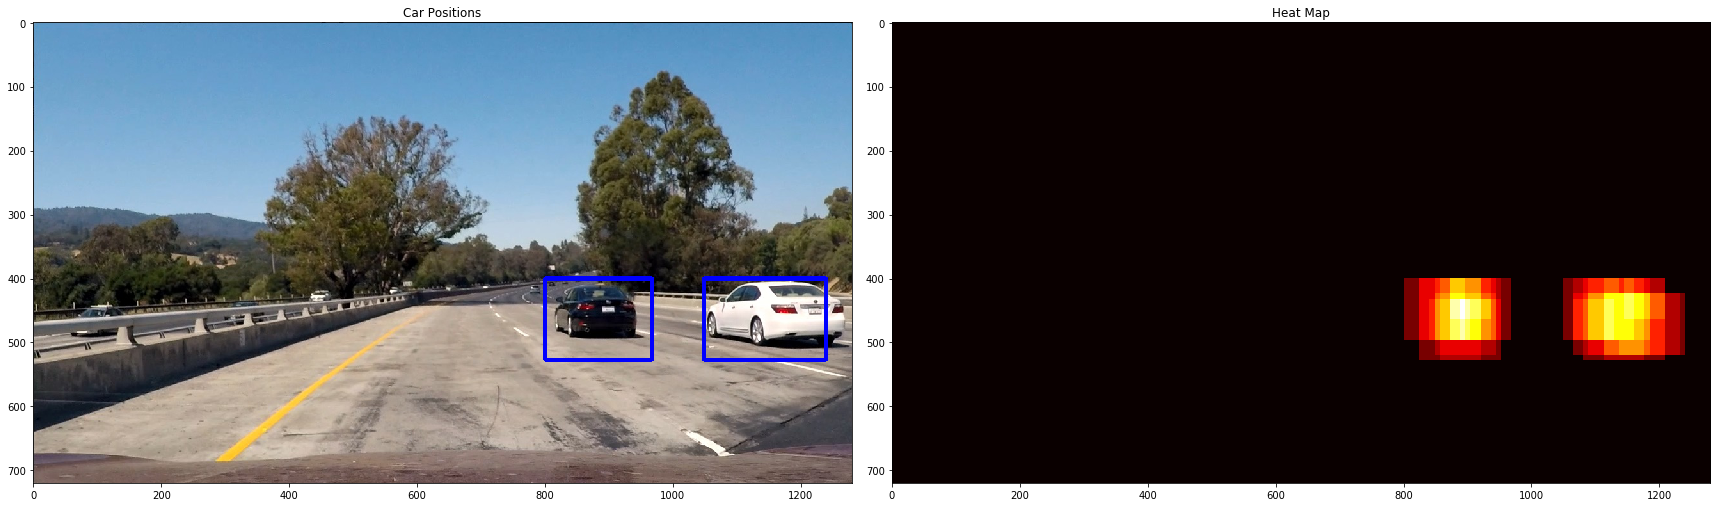

In [15]:
# create heatmap with thresholding - Udacity code
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Read in image similar to one shown above 
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

bgr = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/test1_boundbox.jpg', bgr)

rgb_heatmap = cv2.merge([np.zeros_like(test_img[:,:,0]).astype(np.float), np.zeros_like(test_img[:,:,0]).astype(np.float), heatmap])
rgb_heatmap = rgb_heatmap*20
cv2.imwrite('output_images/test1_heatmap.jpg', rgb_heatmap)

fig = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [25]:
# Video pipeline
import collections
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Creat a deque structure to keep track of the heatmaps from prior frames
# Take 10 frame average
AVG_HEATMAPS = collections.deque(maxlen=10)

def find_boxes(img, xstart, ystart, ystop, scales_list, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    boxes = []
    
    for scale in scales_list:

        ctrans_tosearch = convert_color(img_tosearch, conv='YCrCb')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # = 105
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # = 20
        nfeat_per_block = orient*cell_per_block**2 # = 9*2^2 = 9*4 = 36

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1 # = 7
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # = 49
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step # = 6

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step # position in cells
                xpos = xb*cells_per_step # position in cells
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

                hog_features = []
                hog_features.append(hog_feat1)
                hog_features.append(hog_feat2)
                hog_features.append(hog_feat3)

                hog_features = np.ravel(hog_features) 

                xleft = xpos*pix_per_cell #position in pixels
                ytop = ypos*pix_per_cell #position in pixels

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                window_features = []
                window_features.append(np.concatenate((hog_features, spatial_features, hist_features)))

                # Scale features and make a prediction
                test_features = SAVED_SCALER.transform(window_features)
                test_prediction = SAVED_CLF.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    #cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6)
                    boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                    
    return boxes


def process_image(frame):
    
    global AVG_HEATMAPS
    global colorspace
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    global spatial_size
    global hist_bins
    global XSTART
    global YSTART
    global YSTOP
    global SCALES_LIST

    # Find all matching window of different frame sizes
    box_list = find_boxes(frame, XSTART, YSTART, YSTOP, SCALES_LIST, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    # Read in image similar to one shown above 
    heat = np.zeros_like(frame[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Append heat map to running average of 10 previous frames
    AVG_HEATMAPS.append(heat)
    
    # Sum heatmaps from previous 10 frames
    heat_sum = sum(AVG_HEATMAPS)
    
    # Apply threshold to help remove false positives
    # Set threshold level to 5
    thresh_heat = apply_threshold(heat_sum, 5)
    
    # Find final boxes from heatmap using label function
    labels = label(thresh_heat)
    output_img = draw_labeled_bboxes(np.copy(frame), labels)

    return output_img


project_output = 'output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(project_output, audio=False)

# Clear running average
AVG_HEATMAPS = []

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [1:39:31<00:04,  4.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 1h 39min 32s
